In [18]:
#####################################
# Developed by Baptiste PICARD      #
# picard.baptiste@laposte.net       #
# Started the 03th of May 2020      #
# picard.baptiste@laposte.net       #
#                                   #
# Price prediction of stocks.       #
# Using machine learning.           #
#####################################

# For this project, I set up Pandas to an oldest version. 
# Indeed, I need pandas_datareader to get stock old prices but this module
# isn't compatible with the actual version of Pandas.
# To set up and use this notebook, just open a shell and : conda install pandas==0.24.2
# To get the latest update of pandas : conda install pandas==latest

# Imports 
# Usefull modules
import time
import sys
import warnings
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt 
import matplotlib
import matplotlib.pyplot as plt
import pandas_datareader as pdw

# Preprocessing modules
import keras
import sklearn
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, max_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Models
from keras.models import Sequential, model_from_json # Basis for neural networks model implementation
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten # Standard layers 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor # Gradient Boosting, Random Forest
import xgboost as xgb # X Gradient Boosting (most powerfull)

# Environment
# plt.close('all') # Usefull in .py files, not in notebooks.
plt.style.use('seaborn') # Change the style of the figures.
warnings.filterwarnings('ignore') # Avoid warnings

# CONSTANTS
STOCK_NAME = 'AAPL'
SOURCE = 'yahoo'
START_DATE = dt.date(2010, 1, 1) # "2010-01-01"
END_DATE = dt.date(2020, 1, 1) # "2020-01-01"
TODAY = dt.date.today()

GRAFS = True
SUMMARY = True

if(GRAFS) : # Get environment version.
    print("Python version : {}".format(sys.version))
    print("Numpy version : {}".format(np.__version__))
    print("Pandas version : {}".format(pd.__version__))
    print("Keras version : {}".format(keras.__version__))
    print("Sklearn version : {}".format(sklearn.__version__))
    print("Seaborn version : {}".format(sns.__version__))
    print("Matplotlib version : {}".format(matplotlib.__version__))
    print("Datareader version : {}".format(pdw.__version__))

Python version : 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Numpy version : 1.18.1
Pandas version : 0.24.2
Keras version : 2.2.2
Sklearn version : 0.22.1
Seaborn version : 0.9.0
Matplotlib version : 3.1.3
Datareader version : 0.7.0


In [4]:
df = pdw.DataReader(STOCK_NAME, data_source=SOURCE, start=START_DATE, end=TODAY)
n_rows, n_cols = df.shape
na_values = df.isnull().sum().sum()
object_cols = df.dtypes[df.dtypes == np.object].count()
integer_cols = df.dtypes[df.dtypes == np.int64].count()
float_cols = df.dtypes[df.dtypes == np.float64].count()
print("The dataset is composed by : {} rows/columns.".format(df.shape))
print("There are {} na values of the {} values.".format(na_values, n_rows * n_cols))
print("This dataset is composed by {} object cols / {} int64 cols / {} float64 cols.".format(object_cols, integer_cols, float_cols))

The dataset is composed by : (2603, 6) rows/columns.
There are 0 na values of the 15618 values.
This dataset is composed by 0 object cols / 0 int64 cols / 6 float64 cols.


In [5]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.538483
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.584366
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.161509
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.113146
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.286753


All data : (2603, 5) | Train set : (2342, 5) -> (2342,) | Test set : (261, 5) -> (261,)
Types : X_train : <class 'numpy.ndarray'> / X_test : <class 'numpy.ndarray'>
Beginning shape : X_train : (2342, 5) | X_test : (261, 5)
Beginning shape : y_train : (2342,) | y_test : (261,)
Shapes -> MLP : (5,) | Conv1D : (5, 1) | LSTM : (1, 5).


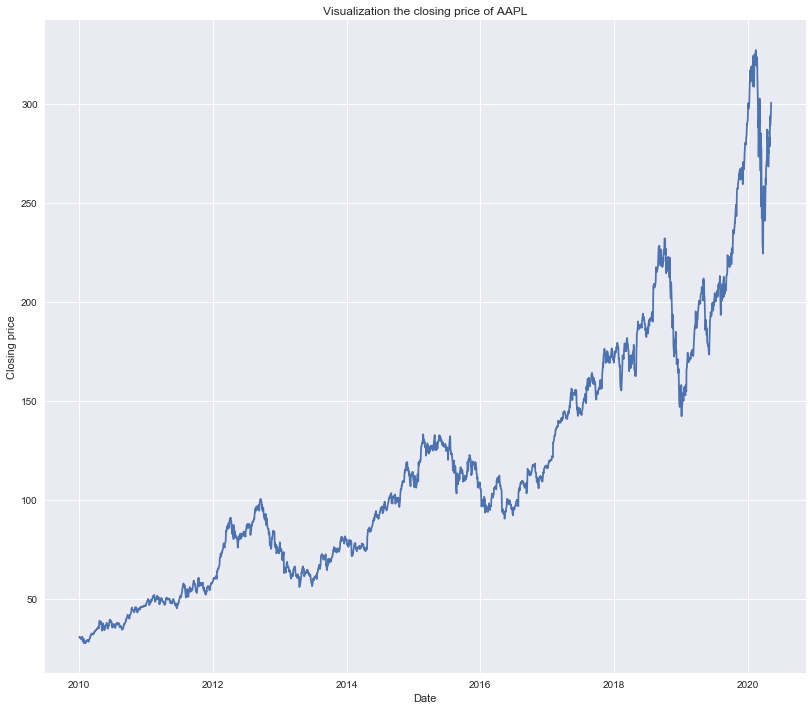

In [6]:
if(GRAFS) :
    plt.figure(figsize=(30,12))
    plt.subplot(121)
    plt.title("Visualization the closing price of "+STOCK_NAME)
    plt.xlabel('Date')
    plt.ylabel('Closing price')
    plt.plot(df['Close'])

scalers = []
# Preprocessing : transfrom the data.
for column in df.columns :
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
    scalers.append({"column_name" : column, "scaler" : scaler})

    
#Transform data from dataframe to numpy array
targets = df['Close'].values
df = df.drop('Close', axis=1).values
n_cols = n_cols - 1
# Spliting the dataset.
# 80 % train - 20 % test.
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.1, random_state=42)
# Preparing the data -> Reshaping. Data prepared for MLP model.
input_shape_MLP = (X_train.shape[1],)
input_shape_Conv1D = (X_train.shape[1], 1)
input_shape_LSTM = (1, X_train.shape[1])
if(GRAFS) :
    print("All data : {} | Train set : {} -> {} | Test set : {} -> {}".format(df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    print("Types : X_train : {} / X_test : {}".format(type(X_train), type(X_test)))
    print("Beginning shape : X_train : {} | X_test : {}".format(X_train.shape, X_test.shape))
    print("Beginning shape : y_train : {} | y_test : {}".format(y_train.shape, y_test.shape))
    print("Shapes -> MLP : {} | Conv1D : {} | LSTM : {}.".format(input_shape_MLP, input_shape_Conv1D, input_shape_LSTM))

In [7]:
%%time
n_rows_train = X_train.shape[0]
n_cols_train = X_train.shape[1]
n_rows_test = X_test.shape[0]
n_cols_test = X_test.shape[1]
epochs = 10

def getModelMLP(input_shape) : # Works
    # Develop the model for close price prediction.
    # Dense and Dropout
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu')) 
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu')) 
    model.add(Dense(16, activation='relu')) 
    model.add(Dropout(0.5))
    model.add(Dense(1)) 
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def getModelLSTM(input_shape) : # Works
    # Develop the model for close price prediction.
    # Dense, LSTM, Dropout
    model = Sequential()
    model.add(LSTM(40, return_sequences=True, activation='relu', input_shape=input_shape))
    model.add(LSTM(40, return_sequences=True, activation='relu')) # , input_shape=input_shape))
    model.add(LSTM(8, return_sequences=False, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation='relu')) 
    model.add(Dense(8, activation='relu')) 
    model.add(Dropout(0.25))
    model.add(Dense(1)) 
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def getModelConv1D(input_shape) : # OK but can't add other Conv1D layer
    # Develop the model for close price prediction.
    # Dense, Conv1D, MaxPolling, Dropout
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=4, padding='same')) 
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=4, padding='same')) 
    model.add(Flatten()) # Don't forget this line !!!!
    model.add(Dropout(0.25)) 
    model.add(Dense(16, activation='relu')) 
    model.add(Dense(8, activation='relu')) 
    model.add(Dropout(0.25))
    model.add(Dense(1)) 
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

models =    [
                {"model_name" : 'LSTM', 'model' : getModelLSTM(input_shape_LSTM), 'history' : None, 'score' : None, 'training_time' : 0},
                {"model_name" : 'Conv1D', 'model' : getModelConv1D(input_shape_Conv1D), 'history' : None, 'score' : None, 'training_time' : 0},
                {"model_name" : 'MLP', 'model' : getModelMLP(input_shape_MLP), 'history' : None, 'score' : None, 'training_time' : 0},
                {"model_name" : 'RandomForest', 'model' : RandomForestRegressor(n_estimators=400, max_depth=12, ccp_alpha=0.3), 'history' : None, 'score' : None, 'training_time' : 0},
                {"model_name" : 'XGB', 'model' : xgb.XGBRegressor(n_estimators=400, max_depth=12, ccp_alpha=0.3), 'history' : None, 'score' : None, 'training_time' : 0},
                {"model_name" : 'GradientBoost', 'model' : GradientBoostingRegressor(n_estimators=400, max_depth=12, ccp_alpha=0.3), 'history' : None, 'score' : None, 'training_time' : 0}
            ]

for index, model in enumerate(models) : 
    print("{}/{} -> Training {}".format(index+1, len(models), model['model_name']))
    t = time.time()
    if(model['model_name'] == 'LSTM') :
        X_train = X_train.reshape(n_rows_train, 1, n_cols_train)
        X_test = X_test.reshape(n_rows_test, 1, n_cols_test)
        y_train = y_train.reshape(n_rows_train, 1)
        y_test = y_test.reshape(n_rows_test, 1)
    elif(model['model_name'] == 'Conv1D') :
        X_train = X_train.reshape(n_rows_train, n_cols_train, 1)
        X_test = X_test.reshape(n_rows_test, n_cols_test, 1)
        y_train = y_train.reshape(n_rows_train, 1)
        y_test = y_test.reshape(n_rows_test, 1)
    else : 
        X_train = X_train.reshape(n_rows_train, n_cols_train)
        X_test = X_test.reshape(n_rows_test, n_cols_test)
        y_train = y_train.reshape(n_rows_train)
        y_test = y_test.reshape(n_rows_test)
    start = time.time()
    if(model['model_name'] == 'LSTM' or model['model_name'] == 'Conv1D' or model['model_name'] == 'MLP') :
        learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                                    patience=3, 
                                                    verbose=1, 
                                                    factor=0.2, 
                                                    min_lr=0.0001)
        model['model'].fit(X_train, y_train, batch_size=1, verbose=0, epochs=epochs, callbacks=[learning_rate_reduction])
    else : 
        model['model'] = model['model'].fit(X_train, y_train)
    model['training_time'] = (time.time() - start)/60
    MSE_score = mean_squared_error(y_test, model['model'].predict(X_test))
    MAE_score = mean_absolute_error(y_test, model['model'].predict(X_test)) 
    ME_score = max_error(y_test, model['model'].predict(X_test))
    EA_score = explained_variance_score(y_test, model['model'].predict(X_test))
    model['score'] = {"MSE" : MSE_score, "MAE" : MAE_score, "ME" : ME_score, "EA" : EA_score}
    print("{}/{} -> {} trained in {} minutes.".format(index+1, len(models), model['model_name'], (time.time() - t)/60))
        

1/6 -> Training LSTM

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1/6 -> LSTM trained in 2.126774859428406 minutes.
2/6 -> Training Conv1D

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2/6 -> Conv1D trained in 0.7006768623987834 minutes.
3/6 -> Training MLP

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3/6 -> MLP trained in 0.36743818124135336 minutes.
4/6 -> Training RandomForest
4/6 -> RandomForest trained in 0.06404644250869751 minutes.
5/6 -> Training XGB
[17:15:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5/6 -> XGB trained in 0.006413185596466064 minutes.
6/6 -> Training GradientBoost
6/6 -> GradientBoost trained in 0.08183594942092895 minutes.
Wall time: 3min 22s


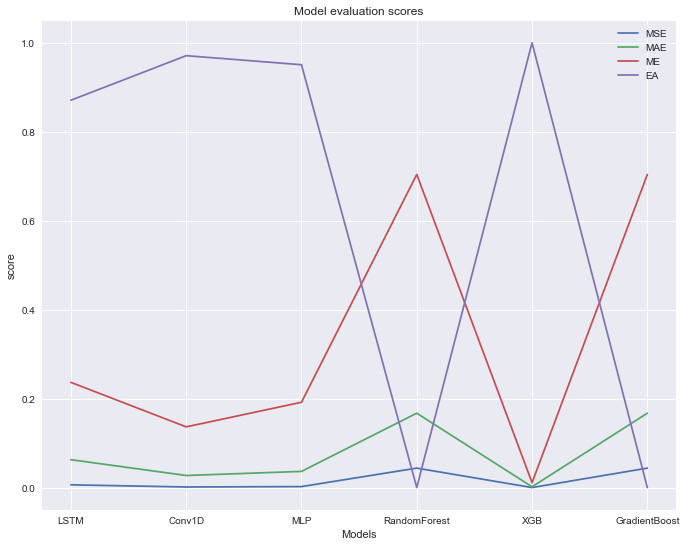

In [8]:
# In this section, I'm plotting my result on the same graf. 
# I want to get a visualization to be able to select the right model.
# For info :
#     - MSE or Mean squared error is a distance calculation between the right score and the predicted score.
#                   It should be as small as possible. best value = 0.0
#     - MAE or Mean absolute error is a distance calculation, absolute this time, between the right score and the predicted score.
#                   It should be as small as possible. best value = 0.0
#     - ME or Max error is a maximum residual error calculation between the right score and the predicted score.
#                   It should be as small as possible. best value = 0.0
#     - EA or Explained variance error is a distance calculation, absolute this time, between the right score and the predicted score.
#                   It should be as big as possible. best value = 1.0
#
# XGB seems to be the best score.

def score(MSE, MAE, ME, EA) :
    return 0.1/MSE + 0.1/MAE + 0.25/ME + EA

X = []
Y_MSE = []
Y_MAE = []
Y_ME = []
Y_EA = []
final_score = []
for model in models :
    X.append(model['model_name'])
    Y_MSE.append(model['score']['MSE'])
    Y_MAE.append(model['score']['MAE'])
    Y_ME.append(model['score']['ME'])
    Y_EA.append(model['score']['EA'])
    final_score.append(score(model['score']['MSE'], model['score']['MAE'], model['score']['ME'], model['score']['EA']))
    
if(GRAFS) :
    plt.figure(figsize=(25,9))
    plt.subplot(121)
    fig = plt.title('Model evaluation scores')
    plt.plot(X, Y_MSE, label='MSE')
    plt.plot(X, Y_MAE, label='MAE')
    plt.plot(X, Y_ME, label='ME')
    plt.plot(X, Y_EA, label='EA')
    plt.ylabel('score')
    plt.xlabel('Models')
    plt.legend()
    
for model in models :
    if(model['history'] != None ):
        if(GRAFS) :
            plt.figure(figsize=(13,5))
            plt.plot(model['history'].history['loss'])
            plt.title('{} loss evolution during training'.format(model['model_name']))
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')

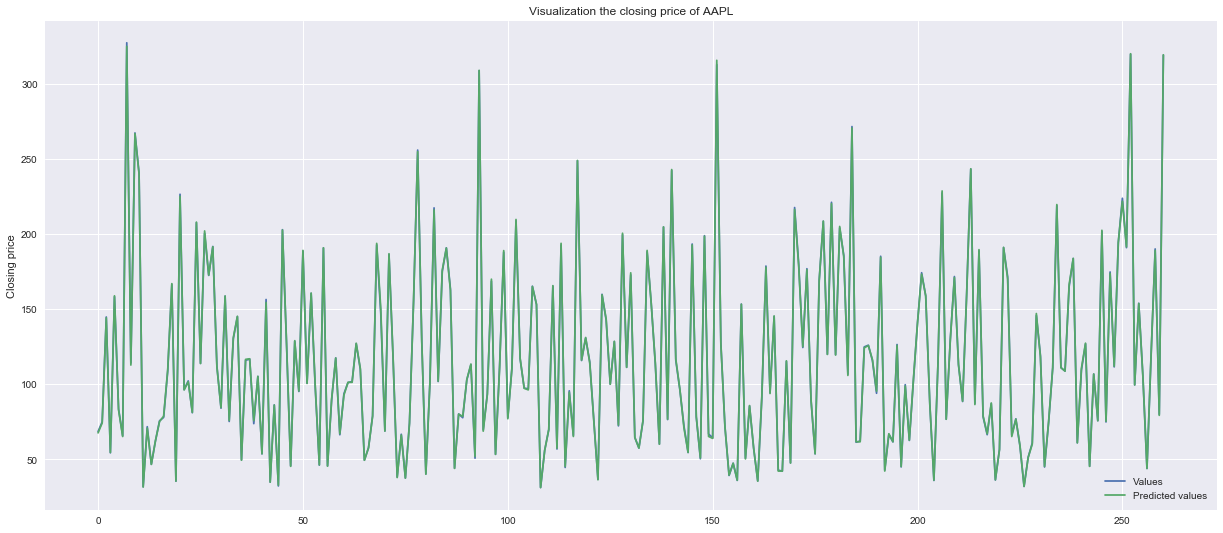

In [21]:
selection = 'XGB'
m = None
if(selection=='LSTM') :
    X_train = X_train.reshape(n_rows_train, 1, n_cols_train)
    X_test = X_test.reshape(n_rows_test, 1, n_cols_test)
    y_train = y_train.reshape(n_rows_train, 1)
    y_test = y_test.reshape(n_rows_test, 1)
if(selection=='Conv1D') :
    X_train = X_train.reshape(n_rows_train, n_cols_train, 1)
    X_test = X_test.reshape(n_rows_test, n_cols_test, 1)
    y_train = y_train.reshape(n_rows_train, 1)
    y_test = y_test.reshape(n_rows_test, 1)
elif(selection=="XGB" or selection=="GradientBoost" or selection=="RandomForest" or selection=="MLP"):
    X_train = X_train.reshape(n_rows_train, n_cols_train)
    X_test = X_test.reshape(n_rows_test, n_cols_test)
    y_train = y_train.reshape(n_rows_train)
    y_test = y_test.reshape(n_rows_test)
for model in models :
    if(str(model['model_name']) == selection) :
        m = model['model']
        
sc = None
for scaler in scalers :
    if(scaler['column_name'] == 'Close') :
        sc = scaler['scaler']
        break 
        
if(GRAFS) : 
    plt.figure(figsize=(21,9))
    plt.title("Visualization the closing price of "+STOCK_NAME)
    plt.plot(sc.inverse_transform(y_test.reshape(-1, 1)), label="Values")
    plt.plot(sc.inverse_transform(m.predict(X_test).reshape(-1, 1)), label="Predicted values")
    plt.ylabel('Closing price')
    plt.legend()

In [25]:
#Saving the model
if(selection=='LSTM' or selection=='MLP' or selection=='Conv1D') : # OK
    model_json = m.to_json()
    with open("./data/model_"+str(selection)+".json", "w") as json_file:
        json_file.write(model_json)
    m.save_weights("./data/model_"+str(selection)+".h5")
elif(selection=="XGB" or selection=="GradientBoost" or selection=="RandomForest") : # OK
    joblib.dump(m, "./data/model_"+str(selection)+".sav")

In [26]:
# loading the model
if(selection=='LSTM' or selection=='MLP' or selection=='Conv1D') : # OK
    json_file = open("./data/model_"+str(selection)+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("./data/model_"+str(selection)+".h5")
elif(selection=="XGB" or selection=="GradientBoost" or selection=="RandomForest") : # OK
    loaded_model = joblib.load("./data/model_"+str(selection)+".sav")

[17:37:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
